In [ ]:
#import dependencies

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


#Download the data

In [ ]:
!curl -o car_fuel_efficiency.csv "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  853k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  853k  100  853k    0     0  1382k      0 --:--:-- --:--:-- --:--:-- 1385k


In [ ]:
df = pd.read_csv ('car_fuel_efficiency.csv')

In [ ]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [ ]:
# Select specific columns
selected_columns = ['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']
df_dataset = df[selected_columns]


In [ ]:
df_dataset.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


Exploratory Data Analysis (EDA)

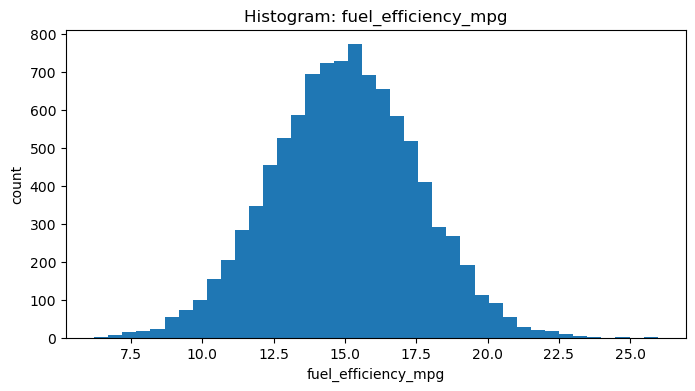

In [ ]:
# Plot histogram of the target variable
plt.figure(figsize=(8, 4))
plt.hist(df['fuel_efficiency_mpg'].dropna(), bins=40)
plt.title('Histogram: fuel_efficiency_mpg')
plt.xlabel('fuel_efficiency_mpg')
plt.ylabel('count')
plt.show()


Validation framework

In [ ]:
from typing import Tuple

def shuffle_split(df: pd.DataFrame, seed: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Shuffle the dataframe using the seed and then split
    into train/val/test with 60% / 20% / 20% proportions.

    Returns: (train_df, val_df, test_df) with indices reset.
    """
    np.random.seed(seed)
    perm = np.random.permutation(len(df))  

    n = len(df)
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)

    train_idx = perm[:n_train]
    val_idx = perm[n_train:n_train + n_val]
    test_idx = perm[n_train + n_val:]

    # return copies with reset index (makes later code simpler)
    return df.iloc[train_idx].reset_index(drop=True), \
           df.iloc[val_idx].reset_index(drop=True), \
           df.iloc[test_idx].reset_index(drop=True)


def prepare_X(df: pd.DataFrame, fill_value=None, fill_with_mean: bool=False, mean_vals: dict=None):
    """
    - Prepare design matrix X (with bias column) and target y.
    - If fill_with_mean is True, fill horsepower NA with mean_vals['horsepower'] (computed on train only).
    - Otherwise fill horsepower with fill_value (e.g., 0).
    """
    df2 = df.copy()
    if fill_with_mean:
        df2['horsepower'] = df2['horsepower'].fillna(mean_vals['horsepower'])
    else:
        df2['horsepower'] = df2['horsepower'].fillna(fill_value)

    features = ['engine_displacement','horsepower','vehicle_weight','model_year']
    X = df2[features].values.astype(float)
    y = df2['fuel_efficiency_mpg'].values.astype(float)

    # Add bias (intercept) column of ones at the first column
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    return X, y

def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Compute root mean squared error."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

Linear Regression

In [ ]:

def linear_regression_closed_form(X: np.ndarray, y: np.ndarray, r: float = 0.0) -> np.ndarray:
    """Compute weights using normal equation with optional L2 regularization (ridge).

    Regularization is NOT applied to the bias term (w[0]) by setting reg[0,0]=0.
    """
    XT_X = X.T.dot(X)
    reg = np.eye(XT_X.shape[0]) * r
    reg[0,0] = 0.0
    w = np.linalg.solve(XT_X + reg, X.T.dot(y))
    return w

Q1: column with missing values

In [ ]:
# Missing values per column
df_dataset.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

Q2: median of horsepower (50th percentile)

In [ ]:
hp_median = df['horsepower'].median()
print(hp_median)

149.0


Q4: Regularized linear regression

In [ ]:
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]
train, val, test = shuffle_split(df, seed=42)
X_train, y_train = prepare_X(train, fill_value=0)
X_val, y_val = prepare_X(val, fill_value=0)

rmse_by_r = {}
for r in r_list:
    w = linear_regression_closed_form(X_train, y_train, r=r)
    pred_val = X_val.dot(w)
    rmse_by_r[r] = round(rmse(y_val, pred_val), 2)

print('Validation RMSE for each r:')
for r, score in rmse_by_r.items():
    print('r =', r, '-> RMSE =', score)

# Choose smallest r among those with minimal RMSE
best_r = min(rmse_by_r.items(), key=lambda kv: (kv[1], kv[0]))[0]
print('\nQ4 answer: best r =', best_r)

Validation RMSE for each r:
r = 0 -> RMSE = 0.52
r = 0.01 -> RMSE = 0.52
r = 0.1 -> RMSE = 0.52
r = 1 -> RMSE = 0.52
r = 5 -> RMSE = 0.52
r = 10 -> RMSE = 0.52
r = 100 -> RMSE = 0.52

Q4 answer: best r = 0


Q5: Seed sensitivity analysis

In [ ]:
seeds = list(range(10))
rmse_scores = []
for s in seeds:
    tr, va, te = shuffle_split(df, seed=s)
    X_tr, y_tr = prepare_X(tr, fill_value=0)
    X_va, y_va = prepare_X(va, fill_value=0)
    w = linear_regression_closed_form(X_tr, y_tr, r=0.0)
    pred_va = X_va.dot(w)
    rmse_scores.append(rmse(y_va, pred_va))

std_scores = round(np.std(rmse_scores), 3)
print('RMSE scores for seeds', seeds)
print([round(x, 3) for x in rmse_scores])
print('\nQ5: std =', std_scores)

RMSE scores for seeds [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[np.float64(0.521), np.float64(0.522), np.float64(0.523), np.float64(0.516), np.float64(0.511), np.float64(0.529), np.float64(0.532), np.float64(0.51), np.float64(0.515), np.float64(0.513)]

Q5: std = 0.007


Q6: Final model evaluation on test set

In [ ]:
# Split with seed 9
train, val, test = shuffle_split(df, seed=9)

# Combine train + val for final training
train_val = pd.concat([train, val]).reset_index(drop=True)

# Prepare arrays, fill NA with 0
X_trval, y_trval = prepare_X(train_val, fill_value=0)
X_test, y_test = prepare_X(test, fill_value=0)

# Fit with r = 0.001
w = linear_regression_closed_form(X_trval, y_trval, r=0.001)

# Evaluate on the test set
pred_test = X_test.dot(w)
rmse_test = round(rmse(y_test, pred_test), 3)
print('Q6: RMSE on test =', rmse_test)

Q6: RMSE on test = 0.515
